In [1]:
import pandas as pd
import networkx as nx
from networkx.algorithms import community
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
redlist = pd.read_csv("../../clean-redlist.csv")
redlist_lc = pd.read_csv("../../clean-redlist-least-concern.csv")
redlist = redlist.append(redlist_lc)
redlist = redlist.iloc[:, 1:]
redlist

,scientificName,redlistCategory,populationTrend,systems,realm,possiblyExtinct,possiblyExtinctInTheWild,longitude,latitude
0,hexanchus griseus,Near Threatened,Decreasing,Marine,NaN,False,False,NaN,NaN
1,heosemys annandalii,Critically Endangered,Decreasing,Terrestrial|Freshwater (=Inland waters),Indomalayan,False,False,NaN,NaN
2,hubbsina turneri,Critically Endangered,Decreasing,Freshwater (=Inland waters),Neotropical,False,False,"[-101.4795, -101.7773, -101.7876]","[19.8745, 19.8256, 19.8273]"
3,hungerfordia pelewensis,Endangered,Unknown,Terrestrial,Oceanian,False,False,NaN,NaN
4,ictalurus mexicanus,Vulnerable,Unknown,Freshwater (=Inland waters),Neotropical,False,False,"[-99.35417, -99.3]","[21.98083, 22.0]"
...,...,...,...,...,...,...,...,...,...
69144,myodes glareolus,Least Concern,Stable,Terrestrial,Palearctic,False,False,NaN,NaN
69145,neomys anomalus,Least Concern,Decreasing,Terrestrial|Freshwater (=Inland waters),Palearctic,False,False,NaN,NaN
69146,melanophylla alnifolia,Least Concern,Decreasing,Terrestrial,Afrotropical,False,False,"[46.38888, 47.23333, 47.26666, 47.2833333, 47....","[-23.46666, -18.15, -18.13333, -18.1783334, -1..."
69147,melanophylla aucubifolia,Least Concern,Decreasing,Terrestrial,Afrotropical,False,False,"[46.39388, 46.53333, 46.54222, 46.89833, 47.00...","[-23.47055, -23.54055, -23.5325, -22.42166, -2..."


In [3]:
interactions = pd.read_csv('../../clean-interactions.csv')
interactions

,sourceTaxonSpeciesName,sourceTaxonKingdomName,interactionTypeName,targetTaxonSpeciesName,targetTaxonKingdomName
0,andrena milwaukeensis,Animalia,visitsFlowersOf,zizia aurea,Plantae
1,andrena mandibularis,Animalia,visitsFlowersOf,zanthoxylum americanum,Plantae
2,andrena edwardsi,Animalia,visitsFlowersOf,wyethia mollis,Plantae
3,andrena mandibularis,Animalia,visitsFlowersOf,viburnum dentatum,Plantae
4,andrena milwaukeensis,Animalia,visitsFlowersOf,viburnum lentago,Plantae
...,...,...,...,...,...
899700,calyptra orthograpta,Animalia,eats,bubalus bubalis,Animalia
899701,calyptra orthograpta,Animalia,eats,cervus unicolor,Animalia
899702,calyptra orthograpta,Animalia,eats,elephas maximus,Animalia
899703,calyptra pseudobicolor,Animalia,eats,homo sapiens,Animalia


In [4]:
# Select entries only in the intersection of both datasets
species = redlist['scientificName']
filter_interactions = interactions[
    interactions['sourceTaxonSpeciesName'].isin(species) &
    interactions['targetTaxonSpeciesName'].isin(species)
]
species = set(filter_interactions['sourceTaxonSpeciesName']) | set(filter_interactions['targetTaxonSpeciesName'])
filter_redlist = redlist[redlist['scientificName'].isin(species)]

In [5]:
graph = nx.from_pandas_edgelist(filter_interactions, 'sourceTaxonSpeciesName', 'targetTaxonSpeciesName')
graph

community count: 1060
average community size: 12.216037735849056
example: {'lemniscomys barbarus', 'sagittarius serpentarius'}
len examples: 309, 233, 266, 7


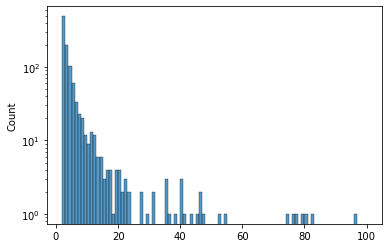

In [6]:
# Calculate communities using a label propagation algorithm
comms1 = list(community.label_propagation.asyn_lpa_communities(graph))

print(f'community count: {len(comms1)}')
print(f'average community size: {sum(map(len, comms1)) / len(comms1)}')
print(f'example: {comms1[200]}')
print(f'len examples: {len(comms1[0])}, {len(comms1[1])}, {len(comms1[2])}, {len(comms1[3])}')
ax = sns.histplot(data=[len(c) for c in comms1], binwidth=1, binrange=(2,100))
ax.set_yscale('log')

community count: 413
average community size: 31.353510895883776


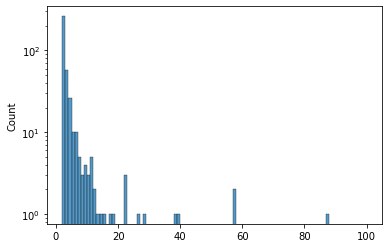

In [7]:
# Other community extraction algorithms for comparison
comms2 = list(community.modularity_max.greedy_modularity_communities(graph))
print(f'community count: {len(comms2)}')
print(f'average community size: {sum(map(len, comms2)) / len(comms2)}')
ax = sns.histplot(data=[len(c) for c in comms2], binwidth=1, binrange=(2,100))
ax.set_yscale('log')

In [8]:
# This one is extremely slow
#comms3 = list(community.centrality.girvan_newman(graph))
#print(f'community count: {len(comms3)}')
#print(f'average community size: {sum(map(len, comms3)) / len(comms3)}')
#ax = sns.histplot(data=[len(c) for c in comms3], binwidth=1, binrange=(2,100))
#ax.set_yscale('log')

In [9]:
# Selecting which algorithm to use
comms = comms2

In [10]:
# Filter only large communities
size_threshold = 2
big_comms = [c for c in comms if len(c) >= size_threshold]
print(f'species removed: <{100*(len(comms2)-len(big_comms))*size_threshold/len(filter_redlist):.2f}%')
print(f'remaining community count: {len(big_comms)}')
print(f'avg big community size: {sum(map(len, big_comms)) / len(big_comms):.2f}')

species removed: <0.00%
remaining community count: 413
avg big community size: 31.35


In [11]:
communities_df = [redlist[redlist['scientificName'].isin(c)] for c in big_comms]

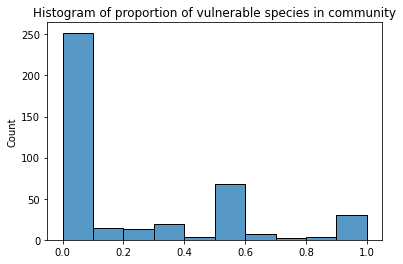

In [12]:
vulnerable_proportion = [(df.redlistCategory != 'Least Concern').mean() for df in communities_df]
ax = sns.histplot(vulnerable_proportion)
_ = ax.set(title='Histogram of proportion of vulnerable species in community')

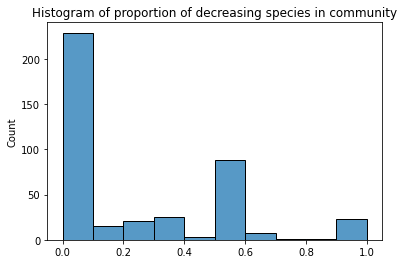

In [13]:
decreasing_proportion = [(df.populationTrend == 'Decreasing').mean() for df in communities_df]
ax = sns.histplot(decreasing_proportion)
_ = ax.set(title='Histogram of proportion of decreasing species in community')

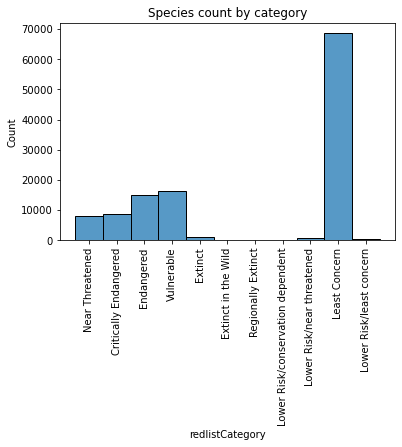

In [14]:
ax = sns.histplot(redlist, x='redlistCategory')
_ = ax.set(title='Species count by category')
_ = plt.xticks(rotation=90)

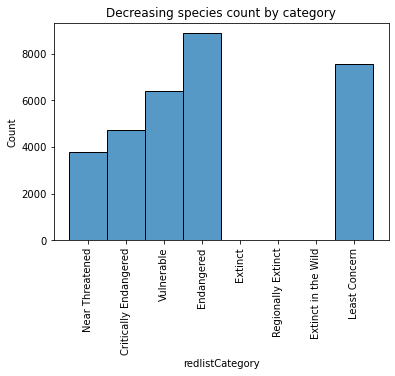

In [15]:
vuln_df = redlist[redlist.populationTrend == 'Decreasing']
ax = sns.histplot(vuln_df, x='redlistCategory')
_ = ax.set(title='Decreasing species count by category')
_ = plt.xticks(rotation=90)

In [16]:
# Calculate some community information
stats = []
for c in communities_df:
    comm_size = len(c)
    comm_size_others = comm_size - 1
    c_vuln = c.redlistCategory != 'Least Concern'
    vuln_count = c_vuln.sum()
    c_dec = c.populationTrend == 'Decreasing'
    dec_count = c_dec.sum()
    for sp in c.itertuples():
        vuln_count_others = vuln_count - int(sp.redlistCategory != 'Least Concern')
        dec_count_others = dec_count - int(sp.populationTrend == 'Decreasing')
        c_same_cat = c.redlistCategory == (c[c.scientificName == sp.scientificName].iloc[0].redlistCategory)
        same_cat_count = c_same_cat.sum() - 1
        stats.append({
            'scientificName': sp.scientificName,
            'redlistCategory': sp.redlistCategory,
            'commSize': comm_size,
            'vulnCount': vuln_count_others,
            'vulnAny': vuln_count_others != 0,
            'vulnAll': vuln_count_others == comm_size_others,
            'vulnProp': vuln_count_others / comm_size_others,
            'vulnMaj': (vuln_count_others / comm_size_others) >= 0.5,
            'sameCatCount': same_cat_count,
            'sameCatAny': same_cat_count != 0,
            'sameCatAll': same_cat_count == comm_size_others,
            'sameCatProp': same_cat_count / comm_size_others,
            'sameCatMaj': (same_cat_count / comm_size_others) >= 0.5,
            'decCount': dec_count_others,
            'decAny': dec_count_others != 0,
            'decAll': dec_count_others == comm_size_others,
            'decProp': dec_count_others / comm_size_others,
            'decMaj': (dec_count_others / comm_size_others) >= 0.5,
        })
stats = pd.DataFrame(stats)
nonvuln = stats[stats.redlistCategory == 'Least Concern']
vuln = stats[stats.redlistCategory != 'Least Concern']
stats

,scientificName,redlistCategory,commSize,vulnCount,vulnAny,vulnAll,vulnProp,vulnMaj,sameCatCount,sameCatAny,sameCatAll,sameCatProp,sameCatMaj,decCount,decAny,decAll,decProp,decMaj
0,hexanchus griseus,Near Threatened,4856,895,True,False,0.184346,False,267,True,False,0.054995,False,1029,True,False,0.211946,False
1,lamna nasus,Vulnerable,4856,895,True,False,0.184346,False,289,True,False,0.059526,False,1029,True,False,0.211946,False
2,hamiota altilis,Endangered,4856,895,True,False,0.184346,False,207,True,False,0.042636,False,1029,True,False,0.211946,False
3,lepus castroviejoi,Vulnerable,4856,895,True,False,0.184346,False,289,True,False,0.059526,False,1029,True,False,0.211946,False
4,malaclemys terrapin,Vulnerable,4856,895,True,False,0.184346,False,289,True,False,0.059526,False,1029,True,False,0.211946,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13235,pseudorabdion longiceps,Least Concern,2,0,False,False,0.000000,False,1,True,True,1.000000,True,0,False,False,0.000000,False
13236,cambarus carinirostris,Least Concern,2,0,False,False,0.000000,False,1,True,True,1.000000,True,0,False,False,0.000000,False
13237,parkesia motacilla,Least Concern,2,0,False,False,0.000000,False,1,True,True,1.000000,True,0,False,False,0.000000,False
13238,phaethornis pretrei,Least Concern,2,0,False,False,0.000000,False,1,True,True,1.000000,True,0,False,False,0.000000,False


Uma espécie é vulnerável se tem classificação `Vulnerable` ou pior

In [17]:
# Todo: mediana
# Todo: Separar nas categorias
print('Número de espécies:')
print(f' - Total: {len(stats)}')
print(f' - Não-vulneráveis: {len(nonvuln)}')
print(f' - Vulneráveis: {len(vuln)}')
print(f'Tamanho médio das comunidades: {sum(map(len, comms)) / len(comms):.2f}')
print('Tamanho médio da comunidade (contando uma vez por espécie):')
print(f' - Geral: {stats.commSize.mean():.2f}')
print(f' - Em não-vulneráveis: {nonvuln.commSize.mean():.2f}')
print(f' - Em vulneráveis: {vuln.commSize.mean():.2f}')

Número de espécies:
 - Total: 13240
 - Não-vulneráveis: 10893
 - Vulneráveis: 2347
Tamanho médio das comunidades: 31.35
Tamanho médio da comunidade (contando uma vez por espécie):
 - Geral: 2486.27
 - Em não-vulneráveis: 2477.79
 - Em vulneráveis: 2525.65


In [18]:
print('Proporção média de espécies vulneráveis da comunidade:')
print(f' - Geral: {stats.vulnProp.mean():.3f}')
print(f' - Em não-vulneráveis: {nonvuln.vulnProp.mean():.3f}')
print(f' - Em vulneráveis: {vuln.vulnProp.mean():.3f}')
print('Quantidade média de espécies vulneráveis na comunidade:')
print(f' - Geral: {stats.vulnCount.mean():.3f}')
print(f' - Em não-vulneráveis: {nonvuln.vulnCount.mean():.3f}')
print(f' - Em vulneráveis: {vuln.vulnCount.mean():.3f}')
print('Probabilidade que alguma espécie da comunidade seja vulnerável:')
print(f' - Geral: {stats.vulnAny.mean():.3f}')
print(f' - Em não-vulneráveis: {nonvuln.vulnAny.mean():.3f}')
print(f' - Em vulneráveis: {vuln.vulnAny.mean():.3f}')
print('Probabilidade que a maioria das espécies da comunidade sejam vulneráveis:')
print(f' - Geral: {stats.vulnMaj.mean():.3f}')
print(f' - Em não-vulneráveis: {nonvuln.vulnMaj.mean():.3f}')
print(f' - Em vulneráveis: {vuln.vulnMaj.mean():.3f}')
print('Probabilidade que todas as espécies da comunidade sejam vulneráveis:')
print(f' - Geral: {stats.vulnAll.mean():.3f}')
print(f' - Em não-vulneráveis: {nonvuln.vulnAll.mean():.3f}')
print(f' - Em vulneráveis: {vuln.vulnAll.mean():.3f}')

Proporção média de espécies vulneráveis da comunidade:
 - Geral: 0.177
 - Em não-vulneráveis: 0.165
 - Em vulneráveis: 0.236
Quantidade média de espécies vulneráveis na comunidade:
 - Geral: 447.533
 - Em não-vulneráveis: 443.028
 - Em vulneráveis: 468.443
Probabilidade que alguma espécie da comunidade seja vulnerável:
 - Geral: 0.940
 - Em não-vulneráveis: 0.935
 - Em vulneráveis: 0.959
Probabilidade que a maioria das espécies da comunidade sejam vulneráveis:
 - Geral: 0.028
 - Em não-vulneráveis: 0.015
 - Em vulneráveis: 0.089
Probabilidade que todas as espécies da comunidade sejam vulneráveis:
 - Geral: 0.010
 - Em não-vulneráveis: 0.007
 - Em vulneráveis: 0.026


In [19]:
print('Proporção média de espécies com mesma categoria na comunidade:')
print(f' - Geral: {stats.sameCatProp.mean():.3f}')
print(f' - Em não-vulneráveis: {nonvuln.sameCatProp.mean():.3f}')
print(f' - Em vulneráveis: {vuln.sameCatProp.mean():.3f}')
print('Quantidade média de espécies com mesma categoria na comunidade:')
print(f' - Geral: {stats.sameCatCount.mean():.3f}')
print(f' - Em não-vulneráveis: {nonvuln.sameCatCount.mean():.3f}')
print(f' - Em vulneráveis: {vuln.sameCatCount.mean():.3f}')
print('Probabilidade de ter alguma espécie com mesma categoria na comunidade:')
print(f' - Geral: {stats.sameCatAny.mean():.3f}')
print(f' - Em não-vulneráveis: {nonvuln.sameCatAny.mean():.3f}')
print(f' - Em vulneráveis: {vuln.sameCatAny.mean():.3f}')
print('Probabilidade de ter a maioria das espécies com mesma categoria na comunidade:')
print(f' - Geral: {stats.sameCatMaj.mean():.3f}')
print(f' - Em não-vulneráveis: {nonvuln.sameCatMaj.mean():.3f}')
print(f' - Em vulneráveis: {vuln.sameCatMaj.mean():.3f}')
print('Probabilidade de ter todas as espécies com mesma categoria na comunidade:')
print(f' - Geral: {stats.sameCatAll.mean():.3f}')
print(f' - Em não-vulneráveis: {nonvuln.sameCatAll.mean():.3f}')
print(f' - Em vulneráveis: {vuln.sameCatAll.mean():.3f}')

Proporção média de espécies com mesma categoria na comunidade:
 - Geral: 0.692
 - Em não-vulneráveis: 0.827
 - Em vulneráveis: 0.064
Quantidade média de espécies com mesma categoria na comunidade:
 - Geral: 1672.133
 - Em não-vulneráveis: 2006.796
 - Em vulneráveis: 118.877
Probabilidade de ter alguma espécie com mesma categoria na comunidade:
 - Geral: 0.980
 - Em não-vulneráveis: 0.992
 - Em vulneráveis: 0.922
Probabilidade de ter a maioria das espécies com mesma categoria na comunidade:
 - Geral: 0.807
 - Em não-vulneráveis: 0.978
 - Em vulneráveis: 0.014
Probabilidade de ter todas as espécies com mesma categoria na comunidade:
 - Geral: 0.055
 - Em não-vulneráveis: 0.065
 - Em vulneráveis: 0.008


In [20]:
print('Proporção média de espécies com população diminuindo na comunidade:')
print(f' - Geral: {stats.decProp.mean():.3f}')
print(f' - Em não-vulneráveis: {nonvuln.decProp.mean():.3f}')
print(f' - Em vulneráveis: {vuln.decProp.mean():.3f}')
print('Quantidade média de espécies com população diminuindo na comunidade:')
print(f' - Geral: {stats.decCount.mean():.3f}')
print(f' - Em não-vulneráveis: {nonvuln.decCount.mean():.3f}')
print(f' - Em vulneráveis: {vuln.decCount.mean():.3f}')
print('Probabilidade de ter alguma espécie com população diminuindo na comunidade:')
print(f' - Geral: {stats.decAny.mean():.3f}')
print(f' - Em não-vulneráveis: {nonvuln.decAny.mean():.3f}')
print(f' - Em vulneráveis: {vuln.decAny.mean():.3f}')
print('Probabilidade de ter a maioria das espécies com população diminuindo na comunidade:')
print(f' - Geral: {stats.decMaj.mean():.3f}')
print(f' - Em não-vulneráveis: {nonvuln.decMaj.mean():.3f}')
print(f' - Em vulneráveis: {vuln.decMaj.mean():.3f}')
print('Probabilidade de ter todas as espécies com população diminuindo na comunidade:')
print(f' - Geral: {stats.decAll.mean():.3f}')
print(f' - Em não-vulneráveis: {nonvuln.decAll.mean():.3f}')
print(f' - Em vulneráveis: {vuln.decAll.mean():.3f}')

Proporção média de espécies com população diminuindo na comunidade:
 - Geral: 0.222
 - Em não-vulneráveis: 0.215
 - Em vulneráveis: 0.255
Quantidade média de espécies com população diminuindo na comunidade:
 - Geral: 557.790
 - Em não-vulneráveis: 554.000
 - Em vulneráveis: 575.380
Probabilidade de ter alguma espécie com população diminuindo na comunidade:
 - Geral: 0.942
 - Em não-vulneráveis: 0.940
 - Em vulneráveis: 0.952
Probabilidade de ter a maioria das espécies com população diminuindo na comunidade:
 - Geral: 0.027
 - Em não-vulneráveis: 0.017
 - Em vulneráveis: 0.074
Probabilidade de ter todas as espécies com população diminuindo na comunidade:
 - Geral: 0.010
 - Em não-vulneráveis: 0.009
 - Em vulneráveis: 0.017
